In [2]:
class TechnologieWissen:
    def __init__(self, name: str, letzte_verwendung: int):
        self.name = name
        self.letzte_verwendung = letzte_verwendung

    def __repr__(self):
        return f"{self.name}: vor {self.letzte_verwendung} Tagen"

class MitarbeiterSkills:
    def __init__(self, name: str, technologien: list[TechnologieWissen]):
        self.name = name
        self.technologien = technologien

    def __repr__(self):
        technologien_str = "\n    ".join([repr(t) for t in self.technologien])
        return (
            f"Mitarbeiter:\n"
            f"  Name: {self.name}\n"
            f"  Skills:\n"
            f"    {technologien_str}"
        )
    
    def to_embedding(self):
        # Konvertiere die Technologien in eine Liste von Strings
        technologien_str = [t.name for t in self.technologien]
        # Erstelle ein Embedding aus den Technologien
        return " ".join(technologien_str)

In [3]:
import json
import random

with open("technologien.json", "r", encoding="utf-8") as f:
    technologien = json.load(f)
with open("namen.json", "r", encoding="utf-8") as f:
    namen = json.load(f)

def get_random_skills():
    skills = []
    for _ in range(1, random.randint(1, 5) + 1):
        tech_name = random.choice(technologien)
        skills.append(TechnologieWissen(tech_name, random.randint(0, 2 * 365)))
    return skills

## Formatieren der Daten

In [4]:
data: list[MitarbeiterSkills] = []

for name in namen:
    skills = get_random_skills()
    mitarbeiter = MitarbeiterSkills(name, skills)
    data.append(mitarbeiter)

for ma in data:
    print(ma)

Mitarbeiter:
  Name: Laura Müller
  Skills:
    Docker: vor 503 Tagen
    Google Cloud: vor 194 Tagen
Mitarbeiter:
  Name: Maximilian Schmidt
  Skills:
    AWS: vor 65 Tagen
    Go: vor 203 Tagen
    Ruby: vor 339 Tagen
    Rust: vor 449 Tagen
Mitarbeiter:
  Name: Anna Fischer
  Skills:
    Git: vor 701 Tagen
    JIRA: vor 374 Tagen
    NumPy: vor 308 Tagen
    Docker: vor 712 Tagen
    Flask: vor 704 Tagen
Mitarbeiter:
  Name: Jonas Wagner
  Skills:
    Flask: vor 303 Tagen
    Ansible: vor 273 Tagen
Mitarbeiter:
  Name: Sofia Hofmann
  Skills:
    Keras: vor 281 Tagen
    Go: vor 483 Tagen
Mitarbeiter:
  Name: Paul Klein
  Skills:
    Django: vor 684 Tagen
    Docker: vor 193 Tagen
    Express.js: vor 648 Tagen
Mitarbeiter:
  Name: Emma Lehmann
  Skills:
    PostgreSQL: vor 57 Tagen
    Power BI: vor 316 Tagen
Mitarbeiter:
  Name: Liam Becker
  Skills:
    Bitbucket: vor 216 Tagen
    Rust: vor 298 Tagen
    Angular: vor 294 Tagen
Mitarbeiter:
  Name: Mia Krüger
  Skills:
    Postgre

## Erstellen der Vektoren (Embeddings)

In [5]:
from openai import OpenAI

client = OpenAI()

def embedd(data):
    return client.embeddings.create(input=data, model="text-embedding-3-small").data[0].embedding

In [6]:
embedded_data = []

for ma in data:
    embedded_data.append(
        embedd(ma.to_embedding())
    )

## Erstellen der Vektordatenbank

In [7]:
import faiss
import numpy as np

dim = len(embedded_data[0])
index = faiss.IndexFlatL2(dim)

embeddings_np = np.array(embedded_data).astype("float32")
index.add(embeddings_np)

## Finden von Clustern mit KMeans

In [36]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 200)

for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(embeddings_np)
    distortions.append(sum(np.min(cdist(embeddings_np, kmeanModel.cluster_centers_, 'euclidean'), axis=1)**2) / embeddings_np.shape[0])
    inertias.append(kmeanModel.inertia_)
    mapping1[k] = distortions[-1]
    mapping2[k] = inertias[-1]

c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.p

Distortion values:
1 : 0.6628633918040897
2 : 0.6260779519648806
3 : 0.6092985524640441
4 : 0.5883266418379196
5 : 0.5720777020865835
6 : 0.5643905867539661
7 : 0.5387897503065759
8 : 0.5212507876665348
9 : 0.5126278290797435
10 : 0.5046011673606129
11 : 0.4947472431613073
12 : 0.48498693228238393
13 : 0.46781401066295486
14 : 0.4608819719547623
15 : 0.4525900359263274
16 : 0.4487408884349147
17 : 0.43537680716604216
18 : 0.43058478808238937
19 : 0.41901887211859434
20 : 0.41186905527374595
21 : 0.41484949623501655
22 : 0.40079611018260225
23 : 0.39362942272972884
24 : 0.38774159707602984
25 : 0.3836564802025323
26 : 0.377264604331896
27 : 0.373625186069854
28 : 0.3702841964899511
29 : 0.3680159105578706
30 : 0.36099998140301687
31 : 0.3504622363573331
32 : 0.3477657696007855
33 : 0.34833841444235825
34 : 0.3429321233391571
35 : 0.340860340047313
36 : 0.34026215496481405
37 : 0.3343810945137485
38 : 0.32976126961588226
39 : 0.32486608324075267
40 : 0.31724518098183563
41 : 0.3118710976

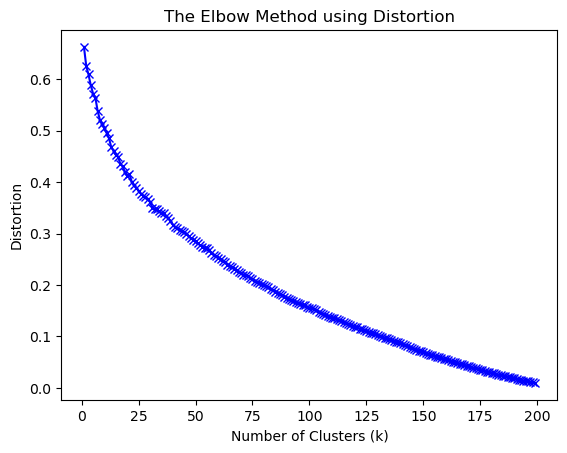

In [37]:
import matplotlib.pyplot as plt

print("Distortion values:")
for key, val in mapping1.items():
    print(f'{key} : {val}')

plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

Inertia values:
1 : 151.13287353515625
2 : 142.74575805664062
3 : 138.92007446289062
4 : 134.1384735107422
5 : 130.4337158203125
6 : 128.6810760498047
7 : 122.84407043457031
8 : 118.84518432617188
9 : 116.87913513183594
10 : 115.04905700683594
11 : 112.80237579345703
12 : 110.57701110839844
13 : 106.66157531738281
14 : 105.08106994628906
15 : 103.19051361083984
16 : 102.31292724609375
17 : 99.26590728759766
18 : 98.17333221435547
19 : 95.53632354736328
20 : 93.9061508178711
21 : 94.585693359375
22 : 91.38150787353516
23 : 89.74749755859375
24 : 88.40507507324219
25 : 87.47367095947266
26 : 86.01632690429688
27 : 85.1865463256836
28 : 84.4247817993164
29 : 83.9076156616211
30 : 82.30799102783203
31 : 79.90538787841797
32 : 79.29058837890625
33 : 79.4211654663086
34 : 78.18852233886719
35 : 77.71615600585938
36 : 77.57977294921875
37 : 76.2388916015625
38 : 75.18558502197266
39 : 74.0694808959961
40 : 72.3319091796875
41 : 71.10661315917969
42 : 70.8692626953125
43 : 70.10712432861328
44

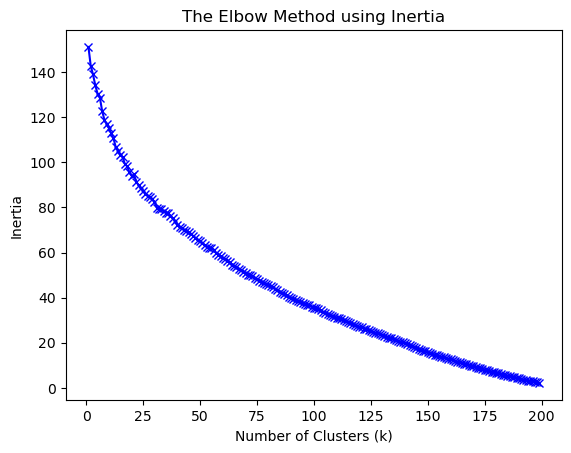

In [38]:
print("Inertia values:")
for key, val in mapping2.items():
    print(f'{key} : {val}')

plt.plot(K, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

### Auswahl der optimalen Clusteranzahl und Clustering der Daten

### Bewertung der Clusterqualität mit dem Silhouette-Score

c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.p

k=2: Silhouette-Score=0.0533
k=3: Silhouette-Score=0.0444
k=4: Silhouette-Score=0.0486
k=5: Silhouette-Score=0.0512
k=6: Silhouette-Score=0.0491
k=7: Silhouette-Score=0.0647


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.p

k=8: Silhouette-Score=0.0711
k=9: Silhouette-Score=0.0745
k=10: Silhouette-Score=0.0723
k=11: Silhouette-Score=0.0757
k=12: Silhouette-Score=0.0773
k=13: Silhouette-Score=0.0892


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.p

k=14: Silhouette-Score=0.0888
k=15: Silhouette-Score=0.0870
k=16: Silhouette-Score=0.0840
k=17: Silhouette-Score=0.0930
k=18: Silhouette-Score=0.0919


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.p

k=19: Silhouette-Score=0.0977
k=20: Silhouette-Score=0.1024
k=21: Silhouette-Score=0.0948
k=22: Silhouette-Score=0.1036


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.p

k=23: Silhouette-Score=0.1033
k=24: Silhouette-Score=0.1045
k=25: Silhouette-Score=0.1044
k=26: Silhouette-Score=0.1084
k=27: Silhouette-Score=0.1083
k=28: Silhouette-Score=0.1056
k=26: Silhouette-Score=0.1084
k=27: Silhouette-Score=0.1083
k=28: Silhouette-Score=0.1056


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=29: Silhouette-Score=0.1057
k=30: Silhouette-Score=0.1138
k=31: Silhouette-Score=0.1222


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=32: Silhouette-Score=0.1247
k=33: Silhouette-Score=0.1176
k=34: Silhouette-Score=0.1194


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=35: Silhouette-Score=0.1146
k=36: Silhouette-Score=0.1120
k=37: Silhouette-Score=0.1146


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=38: Silhouette-Score=0.1168
k=39: Silhouette-Score=0.1185


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=40: Silhouette-Score=0.1228
k=41: Silhouette-Score=0.1228
k=42: Silhouette-Score=0.1185


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.p

k=43: Silhouette-Score=0.1193
k=44: Silhouette-Score=0.1149
k=45: Silhouette-Score=0.1175


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=46: Silhouette-Score=0.1173
k=47: Silhouette-Score=0.1184


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=48: Silhouette-Score=0.1195
k=49: Silhouette-Score=0.1192


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=50: Silhouette-Score=0.1189
k=51: Silhouette-Score=0.1216


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=52: Silhouette-Score=0.1235
k=53: Silhouette-Score=0.1233


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=54: Silhouette-Score=0.1223
k=55: Silhouette-Score=0.1304


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=56: Silhouette-Score=0.1312
k=57: Silhouette-Score=0.1373


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=58: Silhouette-Score=0.1379
k=59: Silhouette-Score=0.1384


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=60: Silhouette-Score=0.1368
k=61: Silhouette-Score=0.1376


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=62: Silhouette-Score=0.1383
k=63: Silhouette-Score=0.1388


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=64: Silhouette-Score=0.1426
k=65: Silhouette-Score=0.1423


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=66: Silhouette-Score=0.1434
k=67: Silhouette-Score=0.1449


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=68: Silhouette-Score=0.1485
k=69: Silhouette-Score=0.1522


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=70: Silhouette-Score=0.1529
k=71: Silhouette-Score=0.1552


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=72: Silhouette-Score=0.1534
k=73: Silhouette-Score=0.1540


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=74: Silhouette-Score=0.1545
k=75: Silhouette-Score=0.1572


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=76: Silhouette-Score=0.1595
k=77: Silhouette-Score=0.1580


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=78: Silhouette-Score=0.1558
k=79: Silhouette-Score=0.1566


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=80: Silhouette-Score=0.1556
k=81: Silhouette-Score=0.1535


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=82: Silhouette-Score=0.1557
k=83: Silhouette-Score=0.1575


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=84: Silhouette-Score=0.1580
k=85: Silhouette-Score=0.1602


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=86: Silhouette-Score=0.1615
k=87: Silhouette-Score=0.1622


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=88: Silhouette-Score=0.1605
k=89: Silhouette-Score=0.1641


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=90: Silhouette-Score=0.1639
k=91: Silhouette-Score=0.1651


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=92: Silhouette-Score=0.1645
k=93: Silhouette-Score=0.1639


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=94: Silhouette-Score=0.1629
k=95: Silhouette-Score=0.1622


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=96: Silhouette-Score=0.1639
k=97: Silhouette-Score=0.1639


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=98: Silhouette-Score=0.1628
k=99: Silhouette-Score=0.1630


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=100: Silhouette-Score=0.1635
k=101: Silhouette-Score=0.1620


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=102: Silhouette-Score=0.1642
k=103: Silhouette-Score=0.1637


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=104: Silhouette-Score=0.1655


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=105: Silhouette-Score=0.1645


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=106: Silhouette-Score=0.1641


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=107: Silhouette-Score=0.1652
k=108: Silhouette-Score=0.1664


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=109: Silhouette-Score=0.1669
k=110: Silhouette-Score=0.1644


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=111: Silhouette-Score=0.1632


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=112: Silhouette-Score=0.1655


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=113: Silhouette-Score=0.1702


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=114: Silhouette-Score=0.1698


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=115: Silhouette-Score=0.1705
k=116: Silhouette-Score=0.1701


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=117: Silhouette-Score=0.1701
k=118: Silhouette-Score=0.1705


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=119: Silhouette-Score=0.1702


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=120: Silhouette-Score=0.1720


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=121: Silhouette-Score=0.1713


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=122: Silhouette-Score=0.1758
k=123: Silhouette-Score=0.1743


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=124: Silhouette-Score=0.1735


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=125: Silhouette-Score=0.1745


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=126: Silhouette-Score=0.1744


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=127: Silhouette-Score=0.1724


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=128: Silhouette-Score=0.1717


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=129: Silhouette-Score=0.1721


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=130: Silhouette-Score=0.1710


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=131: Silhouette-Score=0.1712


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=132: Silhouette-Score=0.1741


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=133: Silhouette-Score=0.1747


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=134: Silhouette-Score=0.1720


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=135: Silhouette-Score=0.1712


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=136: Silhouette-Score=0.1705


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=137: Silhouette-Score=0.1692


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=138: Silhouette-Score=0.1690


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=139: Silhouette-Score=0.1696


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=140: Silhouette-Score=0.1695


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=141: Silhouette-Score=0.1694


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=142: Silhouette-Score=0.1710


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=143: Silhouette-Score=0.1714


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=144: Silhouette-Score=0.1705


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=145: Silhouette-Score=0.1699


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=146: Silhouette-Score=0.1735


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=147: Silhouette-Score=0.1739


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=148: Silhouette-Score=0.1753


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=149: Silhouette-Score=0.1669


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=150: Silhouette-Score=0.1701


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=151: Silhouette-Score=0.1738


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=152: Silhouette-Score=0.1721


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=153: Silhouette-Score=0.1739


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=154: Silhouette-Score=0.1718


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=155: Silhouette-Score=0.1716


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=156: Silhouette-Score=0.1714


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=157: Silhouette-Score=0.1711


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=158: Silhouette-Score=0.1697


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=159: Silhouette-Score=0.1702


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=160: Silhouette-Score=0.1694


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=161: Silhouette-Score=0.1681


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=162: Silhouette-Score=0.1678


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=163: Silhouette-Score=0.1683


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=164: Silhouette-Score=0.1694


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=165: Silhouette-Score=0.1704


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=166: Silhouette-Score=0.1693


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=167: Silhouette-Score=0.1682


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=168: Silhouette-Score=0.1674


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=169: Silhouette-Score=0.1667


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=170: Silhouette-Score=0.1685


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=171: Silhouette-Score=0.1678


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=172: Silhouette-Score=0.1678


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=173: Silhouette-Score=0.1670


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=174: Silhouette-Score=0.1665


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=175: Silhouette-Score=0.1659


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=176: Silhouette-Score=0.1655


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=177: Silhouette-Score=0.1642


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=178: Silhouette-Score=0.1633


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=179: Silhouette-Score=0.1623


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=180: Silhouette-Score=0.1620


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=181: Silhouette-Score=0.1608


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=182: Silhouette-Score=0.1606


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=183: Silhouette-Score=0.1592


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=184: Silhouette-Score=0.1579


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=185: Silhouette-Score=0.1569


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=186: Silhouette-Score=0.1551


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=187: Silhouette-Score=0.1537


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=188: Silhouette-Score=0.1524


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=189: Silhouette-Score=0.1524


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=190: Silhouette-Score=0.1525


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=191: Silhouette-Score=0.1513


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=192: Silhouette-Score=0.1519


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=193: Silhouette-Score=0.1502


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=194: Silhouette-Score=0.1497


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=195: Silhouette-Score=0.1487


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=196: Silhouette-Score=0.1478


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=197: Silhouette-Score=0.1469


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=198: Silhouette-Score=0.1460


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=199: Silhouette-Score=0.1455


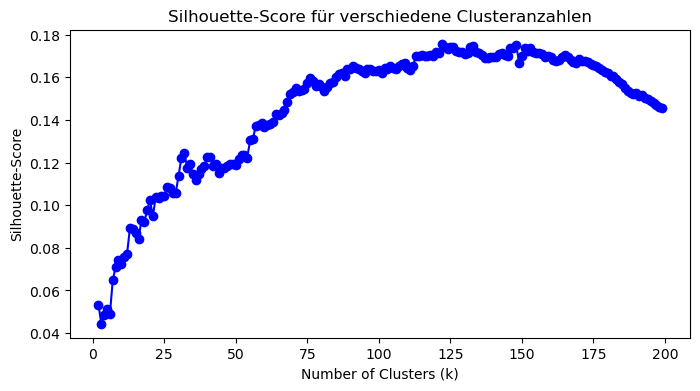

In [40]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
K_sil = range(2, 200)  # Silhouette-Score ist für k=1 nicht definiert

for k in K_sil:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(embeddings_np)
    labels = kmeans.labels_
    score = silhouette_score(embeddings_np, labels)
    silhouette_scores.append(score)
    print(f"k={k}: Silhouette-Score={score:.4f}")

plt.figure(figsize=(8, 4))
plt.plot(K_sil, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette-Score')
plt.title('Silhouette-Score für verschiedene Clusteranzahlen')
plt.show()

In [52]:
# Wähle die optimale Anzahl an Clustern (z.B. aus dem Elbow-Plot)
k_optimal = 8  # Passe diesen Wert ggf. nach Betrachtung des Elbow-Plots an

kmeans = KMeans(n_clusters=k_optimal, random_state=42)
clusters = kmeans.fit_predict(embeddings_np)

print(f"Cluster-Zugehörigkeiten für k={k_optimal}:", clusters)

Cluster-Zugehörigkeiten für k=8: [0 5 1 3 0 3 7 2 1 5 0 1 1 7 0 2 5 0 2 4 0 1 0 0 2 7 1 0 1 7 1 2 3 0 7 0 0
 4 4 2 6 4 1 7 3 0 5 2 4 7 1 2 4 5 1 4 5 1 6 4 0 7 1 2 7 5 7 5 2 0 5 1 2 5
 2 0 6 5 5 3 7 6 6 1 6 0 0 5 1 1 3 2 1 7 7 0 2 3 7 5 5 0 1 5 6 0 5 1 5 2 0
 0 5 3 5 3 6 1 5 6 6 3 0 0 1 1 3 3 0 6 5 1 1 4 4 6 6 2 2 3 7 5 2 3 6 5 1 4
 4 1 4 4 7 7 2 1 1 6 7 3 2 1 1 1 4 5 7 3 4 3 5 2 4 2 5 4 5 0 6 6 1 5 1 3 6
 4 2 5 0 5 2 0 2 1 0 6 0 3 6 1 1 5 2 6 2 5 4 5 6 6 5 0 4 5 5 2 5 1 7 3 1 3
 1 0 4 1 3 5]


c:\Users\TimoAntoniak\miniconda3\envs\vdb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


## Suche in der Vektordatenbank

In [53]:
query = "Backend Technologien"
query_vector = client.embeddings.create(input=query, model="text-embedding-3-small").data[0].embedding

search_vector = np.array([query_vector]).astype('float32')

erg_anzahl = 5

D, indices = index.search(search_vector, erg_anzahl)

print(f"Distances: {D}")
print(f"Indices: {indices}")

for i in indices[0]:
    print(data[i])

Distances: [[1.3219886 1.3232605 1.3464255 1.3523738 1.3574529]]
Indices: [[ 99  15  39 127 218]]
Mitarbeiter:
  Name: Linda Voigt
  Skills:
    MySQL: vor 230 Tagen
    Confluence: vor 641 Tagen
    TensorFlow: vor 539 Tagen
    Jenkins: vor 84 Tagen
    Angular: vor 185 Tagen
Mitarbeiter:
  Name: Finn Neumann
  Skills:
    MySQL: vor 219 Tagen
Mitarbeiter:
  Name: Lena Richter
  Skills:
    Git: vor 635 Tagen
    JavaScript: vor 409 Tagen
Mitarbeiter:
  Name: Carla Pietsch
  Skills:
    React: vor 660 Tagen
    PHP: vor 137 Tagen
    Django: vor 304 Tagen
    Java: vor 565 Tagen
Mitarbeiter:
  Name: Dorothee Hermes
  Skills:
    Azure: vor 585 Tagen
    Confluence: vor 49 Tagen
    Tableau: vor 212 Tagen


## Darstellen mit t-SNE

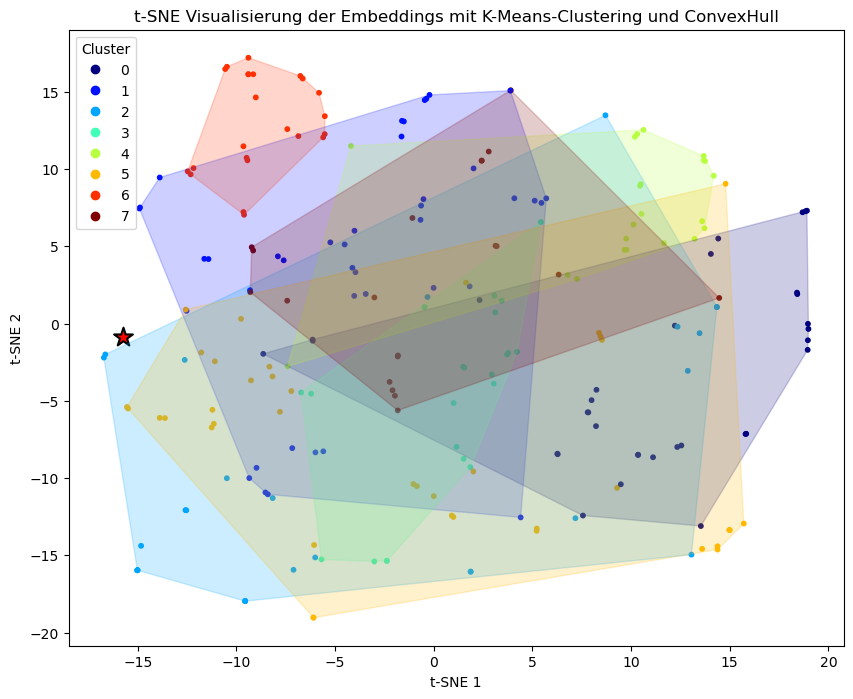

In [56]:
import numpy as np
from sklearn.manifold import TSNE
from scipy.spatial import ConvexHull
import matplotlib

# Kombiniere Embeddings und Query-Vektor für t-SNE
all_embeddings = np.vstack([embeddings_np, search_vector])
tsne = TSNE(n_components=2, random_state=42, perplexity=5, max_iter=300)
reduced_all = tsne.fit_transform(all_embeddings)
reduced_embeddings = reduced_all[:-1]
query_tsne = reduced_all[-1]

# Plotten der reduzierten Embeddings
plt.figure(figsize=(10, 8))
cmap = plt.get_cmap('jet')
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap=cmap, s=10)
plt.scatter(query_tsne[0], query_tsne[1], s=200, c="red", marker="*", edgecolor="black", linewidths=1.5, label="Query-Vektor")

# ConvexHull für jeden Cluster zeichnen, Farbe passend zu den Punkten
unique_clusters = np.unique(clusters)
for cluster_id in unique_clusters:
    points = reduced_embeddings[clusters == cluster_id]
    if len(points) >= 3:
        hull = ConvexHull(points)
        hull_points = points[hull.vertices]
        color = cmap(cluster_id / (len(unique_clusters)-1) if len(unique_clusters) > 1 else 0)
        plt.fill(hull_points[:, 0], hull_points[:, 1], alpha=0.2, color=color, edgecolor=color)

# Optional: Titel und Achsenbeschriftungen hinzufügen
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.title("t-SNE Visualisierung der Embeddings mit K-Means-Clustering und ConvexHull")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

plt.show()

